In [337]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [338]:
df = pd.read_csv('loan_data.csv')

In [339]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (10500, 12)


In [340]:
df.head()

,age,annual_income,employment_years,loan_amount,loan_term_months,interest_rate,credit_score,num_credit_lines,num_delinquent_accounts,monthly_payment_capacity,last_audit_team_id,loan_defaulted
0,19,22908.82,2.9,14875.88,36,6.10,815,3,1,1455.84,14,0
1,36,36668.93,2.3,5231.74,24,11.78,531,3,1,2810.01,0,1
2,37,69966.37,8.6,3982.80,36,9.71,598,0,0,5702.56,1,0
3,54,54911.70,6.3,11008.30,36,11.16,558,3,0,4214.74,5,1
4,27,102776.44,0.7,22460.92,24,8.71,640,4,0,7541.57,14,0


In [341]:
print("Target distribution:")
df['loan_defaulted'].value_counts(normalize=True)

Target distribution:


loan_defaulted
0    0.772
1    0.228
Name: proportion, dtype: float64

In [342]:
print("Missing values:")
df.isnull().sum()

Missing values:


age                         0
annual_income               0
employment_years            0
loan_amount                 0
loan_term_months            0
interest_rate               0
credit_score                0
num_credit_lines            0
num_delinquent_accounts     0
monthly_payment_capacity    0
last_audit_team_id          0
loan_defaulted              0
dtype: int64

### Data Visualization

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

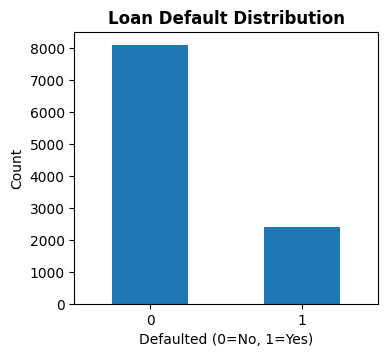

In [343]:
fig = plt.figure(figsize=(18, 12))

plt.subplot(3, 4, 1)
df['loan_defaulted'].value_counts().plot(kind='bar')
plt.title('Loan Default Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Defaulted (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)

Text(0, 0.5, 'Age')

<Figure size 900x600 with 0 Axes>

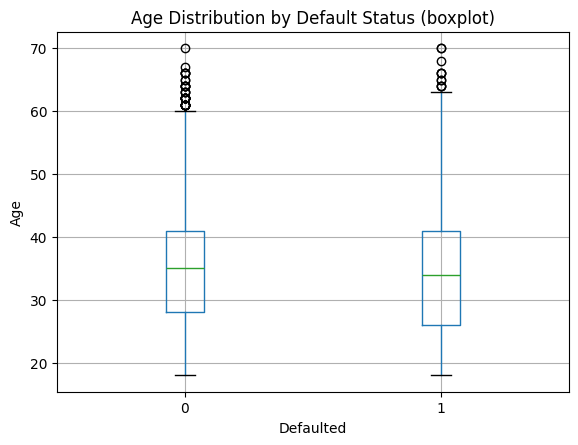

In [344]:
fig = plt.figure(figsize=(9, 6))

df.boxplot(column='age', by='loan_defaulted')
plt.title('Age Distribution by Default Status (boxplot)')
plt.suptitle('')
plt.xlabel('Defaulted')
plt.ylabel('Age')

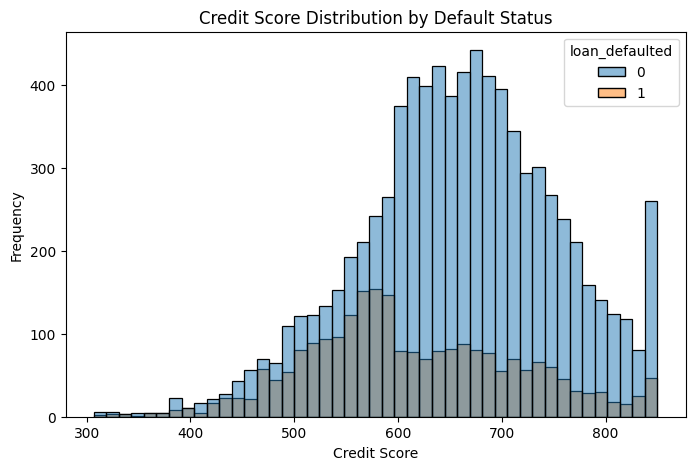

In [345]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df,  x='credit_score', hue='loan_defaulted', multiple='layer')

plt.title('Credit Score Distribution by Default Status')
plt.xlabel('Credit Score')
_ = plt.ylabel('Frequency')

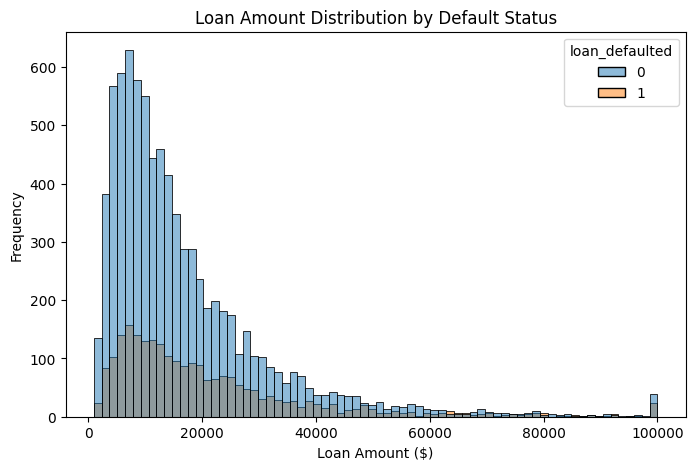

In [346]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df,  x='loan_amount', hue='loan_defaulted', multiple='layer')

plt.title('Loan Amount Distribution by Default Status')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Frequency')

plt.show()

Text(0, 0.5, 'Interest Rate (%)')

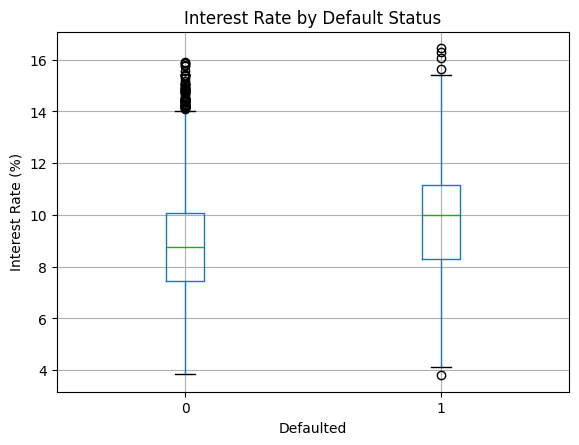

In [347]:
df.boxplot(column='interest_rate', by='loan_defaulted')
plt.title('Interest Rate by Default Status')
plt.suptitle('')
plt.xlabel('Defaulted')
plt.ylabel('Interest Rate (%)')

Text(0.5, 1.0, 'Frequency of last_audit_team_id')

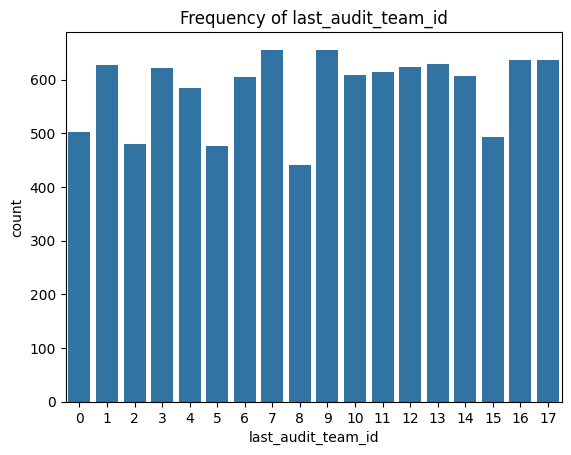

In [348]:
sns.countplot(x='last_audit_team_id', data=df)

plt.title('Frequency of last_audit_team_id')

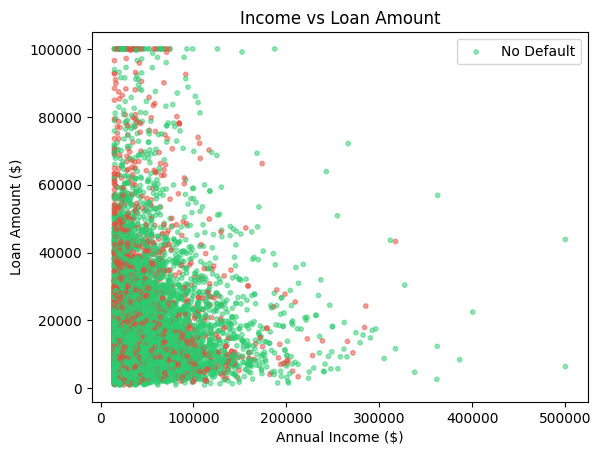

In [349]:
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in df['loan_defaulted']]
plt.scatter(df['annual_income'], df['loan_amount'], c=colors, alpha=0.5, s=10)
plt.title('Income vs Loan Amount')
plt.xlabel('Annual Income ($)')
plt.ylabel('Loan Amount ($)')
plt.legend(['No Default', 'Default'])

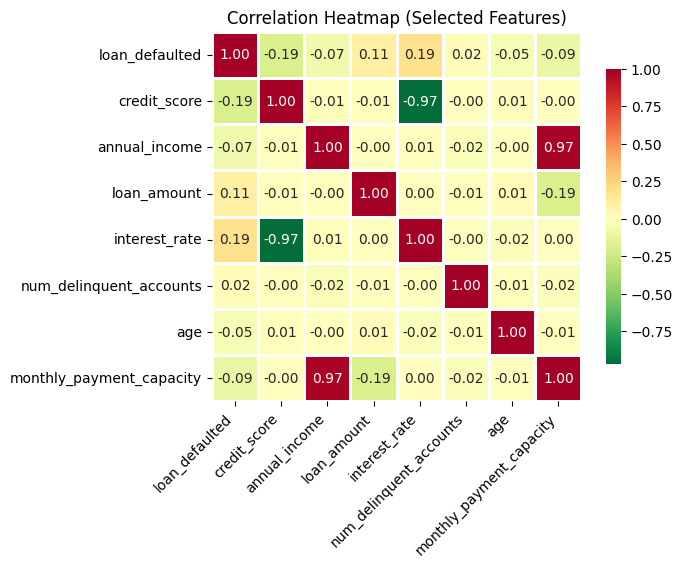

In [350]:
corr_cols = ['loan_defaulted', 'credit_score', 'annual_income', 
             'loan_amount', 'interest_rate', 'num_delinquent_accounts', 'age', 'monthly_payment_capacity']
corr_matrix = df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Selected Features)')
plt.xticks(rotation=45, ha='right')
_= plt.yticks(rotation=0)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '12'),
  Text(1, 0, '24'),
  Text(2, 0, '36'),
  Text(3, 0, '48'),
  Text(4, 0, '60')])

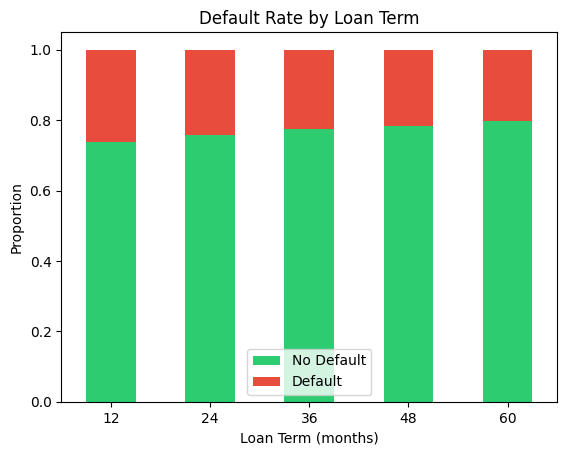

In [351]:
term_default = pd.crosstab(df['loan_term_months'], df['loan_defaulted'], normalize='index')
term_default.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#2ecc71', '#e74c3c'])
plt.title('Default Rate by Loan Term')
plt.xlabel('Loan Term (months)')
plt.ylabel('Proportion')
plt.legend(['No Default', 'Default'])
plt.xticks(rotation=0)

## Data Preprocessing and Feature Engineering

Investigate each section carefully and apply the necessary fixes.

## Data Leak couses
- The duplicates in the dataset
- The data that will not be available at the time of prediction aka monthly_payment_capacity
- The last_audit_team_id was really correlated with the target variable and did not make any sense to be there

In [ ]:
print(f"Original dataset shape: {df.shape}")
print(f"Duplicated records: {df.duplicated().sum()}")
#deleting duplicates
df = df.drop_duplicates().reset_index(drop=True)
# display(df)


display(df.groupby('loan_defaulted')['monthly_payment_capacity'].describe())
# Check correlation with target
# print(f"Correlation with target: {df['monthly_payment_capacity'].corr(df['loan_defaulted'])}")

# If correlation is < -0.3 or model accuracy drops significantly when you remove it, it's leaking
# print(f"Duplicated records: {selected.duplicated().sum()}")
# display(selected)
display(df.columns)
# Droping monthly_payment_capacity and last_audit_team_id
safe_cols = ["age", "annual_income", "employment_years", "loan_amount",
             "loan_term_months", "interest_rate", "credit_score",
             "num_credit_lines", "num_delinquent_accounts", "loan_defaulted"]
df = df[safe_cols].copy()

print(f"Dataset shape after removing leakage: {df.shape}")
print(f"Dataset shape after FIX 1: {df.shape}")


Original dataset shape: (10500, 12)
Duplicated records: 500


,count,mean,std,min,25%,50%,75%,max
loan_defaulted,,,,,,,,
0,7712.0,3436.801128,3191.346637,-6951.93,1417.2650,2588.35,4490.410,41375.47
1,2288.0,2722.830516,2977.991899,-6962.95,973.8825,1949.02,3589.735,25142.68


Index(['age', 'annual_income', 'employment_years', 'loan_amount',
       'loan_term_months', 'interest_rate', 'credit_score', 'num_credit_lines',
       'num_delinquent_accounts', 'monthly_payment_capacity',
       'last_audit_team_id', 'loan_defaulted'],
      dtype='object')

Dataset shape after removing leakage: (10000, 10)
Dataset shape after FIX 1: (10000, 10)


In [296]:
X = df.drop(columns=['loan_defaulted']).copy()
y = df['loan_defaulted'].copy()

# Feature engineering
X['debt_to_income_ratio'] = (X['loan_amount'] / X['annual_income']).round(4)
X['loan_term_risk'] = (X['loan_term_months'] / 12 * X['interest_rate']).round(2)

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Feature matrix shape: (10000, 11)
Features: ['age', 'annual_income', 'employment_years', 'loan_amount', 'loan_term_months', 'interest_rate', 'credit_score', 'num_credit_lines', 'num_delinquent_accounts', 'debt_to_income_ratio', 'loan_term_risk']


In [297]:
feature_cols = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"StandardScaler applied Shape: {X.shape}")


StandardScaler applied Shape: (10000, 11)


### Train/test split

In [298]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (8000, 11)
Test set shape: (2000, 11)


### 📤 Save Preprocessed Data for Submission

**IMPORTANT:** Run the cell below to generate `loan_data_preprocessed.csv` - this is the file you will submit for evaluation.

The evaluator will compare your submission against expected outputs to determine which fixes you implemented correctly.

---
**⚠️ DO NOT MODIFY THE CELL BELOW** - it generates your submission file correctly.
---

In [299]:
train_df_preprocessed = X_train.copy()
test_df_preprocessed = X_test.copy()

train_df_preprocessed['loan_defaulted'] = y_train.values
test_df_preprocessed['loan_defaulted'] = y_test.values

preprocessed_df = pd.concat([train_df_preprocessed, test_df_preprocessed], ignore_index=True)

# Save the final preprocessed data to a CSV file
preprocessed_df.to_csv('loan_data_preprocessed.csv', index=False)

print("Preprocessed data saved successfully.")
print(f"Shape of the saved data: {preprocessed_df.shape}")

Preprocessed data saved successfully.
Shape of the saved data: (10000, 12)


### Model

In [300]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,         
    min_samples_leaf=5,    
    random_state=42
)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Evaluation

In [301]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.8304
Test Accuracy: 0.7655


### Feature importance

In [302]:
print("Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance

Top 10 Most Important Features:


,feature,importance
6,credit_score,0.197844
9,debt_to_income_ratio,0.143547
5,interest_rate,0.136379
3,loan_amount,0.103718
10,loan_term_risk,0.102739
1,annual_income,0.091484
0,age,0.083507
2,employment_years,0.074309
7,num_credit_lines,0.033808
4,loan_term_months,0.020977
